In [1]:
import torch
from torch.distributions import Categorical
import random
import itertools
import numpy as np
import copy
import torch
from torch import nn
from torch.nn import functional as F
from copy import deepcopy
import math 
import numpy as np
from Model.Config import *
from Model.AMO import * 
from Ant_k_starts import *
from Normalize_data import *
from Ant import *
from Injection import *
from Cross_Exchange import *
from Local_search import * 
from Draw import *


In [2]:
device = None
cfg = Data_100()

EPS = 1e-10
model = Net3().to(device)
model.load_state_dict(torch.load('AMO_ACO_{}.pt'.format(cfg.graph_size), map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
pyg_data_normalize = normalize_data(cfg)
heuristic_measure, log, topk = model(pyg_data_normalize)
heuristic_measure = heuristic_measure.reshape((cfg.graph_size+1, cfg.graph_size+1))

In [4]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()
data = torch.tensor([[float(x) for x in y] for y in data])
tsp_coordinates = data[:, 1:3] 
demands = torch.tensor(demand, dtype = torch.float32)
time_window = data[:, 4:]
durations = time_window[:, -1] 
distances = gen_distance_matrix(tsp_coordinates, device = device)

aco = ACO(distances, demands, time_window, 10, topk, max_cap, heuristic=heuristic_measure, n_ants=cfg.n_ants)

In [5]:
max_cap, xcoord, ycoord, demand, e_time, l_time, s_time, data = load_data()

CAP=max_cap
colony=Ant(data,CAP,0.7, heuristic_measure)
colony.customer_cord()
colony.euclidean_distance()
colony.width_window()
_ = colony.path_pheromon()

In [6]:
def convert_dict(path): # path: tensor depot 0(m,)
    path += 1
    path = path.to(torch.long)
    zero_indices = torch.where(path == 1)[0]
    zero_indices = zero_indices.tolist()
    path = path.tolist()
    while zero_indices[-1] - zero_indices[-2] == 1:
        zero_indices.pop()
    dict = {}
    for i in range(len(zero_indices) - 1):
        dict[i] = path[zero_indices[i]: zero_indices[i+1] + 1 ]
    return dict

In [7]:
def update_btnt(path, cost, pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost):
    '''
    path: Loi giai tiem nang
    cost: ham cost cua loi giai
    pheromone: aco.pheromone
    effort: so iter truoc khi ket thuc
    '''
    if cost < best_cost:
        reward = int(k_candidate * prob_to_update * reward_coff) * effort
    else:
        reward = int(k_candidate * prob_to_update) * effort
    for route in path.values(): # route
        for l in range(len(route) - 1):
            pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += reward/cost
    reward_coff += 2
    return reward_coff, pheromone
    

In [8]:
import time
max_iteration = 500
n_customer = len(data)
k_candidate = 100
prob_to_update = 0.05
best = 1e10
best_cost = 1e10
aco.decay = 1
aco.beta = 0.5
elitism_set = 0
reward_coff = 2
effort = 0
final_path = 0
prob_to_destroy = 0.05
cnt = 0
counter = 0
best_data = []
best_cost_data = []
destroy_data = []
t1 = time.time()


def save_solution(ants_route, travel_distance, BTNT, max_route, max_travel):
    if len(ants_route.keys()) < max_route:
        BTNT[-1] = ants_route
        max_travel = travel_distance
        max_route = len(ants_route.keys())
    elif len(ants_route.keys()) == max_route and travel_distance < max_travel:
        BTNT[-1] = ants_route
        max_travel = travel_distance
        max_route = len(ants_route.keys())
    return BTNT, max_travel, max_route


BTNT = [0]
max_travel = 1e10

max_route = int(n_customer)
for k in range(max_iteration):

    paths, costs = aco.run()
    '''
    TO DO:
    - Chon 100 paths co gia tri tot nhat # DONE 
    - Xay ham chuyen paths ve dinh dang dictionary nhu BTNT_IBSO_ACO # DONE
    - Mode colony # DONE
    - Thuc hien Injection va Cross Exchange # DONE 
    - Thuc hien Local Search ngau nhien # DONE
    - Xac suat lua chon < 0.3 # DONE
    - continue
    '''
    local_path = []
    candidate_values, indexs = torch.topk(costs, k = k_candidate, largest=False)
    candidate_path = paths.T[indexs] # (k * prob_size)
    for i, (value, path) in enumerate(zip(candidate_values, candidate_path)):
        ants_route = convert_dict(path)
        if torch.rand(1) < prob_to_update:
            travel_distance, ants_route = injection(ants_route, colony, 0.5)
            travel_distance, ants_route = cross_exchange(ants_route, colony)
            travel_distance, ants_route = ls_1route(ants_route, colony)
            travel_distance, ants_route = ls3(ants_route)
            BTNT, max_travel, max_route = save_solution(ants_route, travel_distance, BTNT, max_route, max_travel)
            candidate_values[i] = travel_distance
        local_path.append(ants_route)
    
    aco.pheromone *= aco.decay
    value_to_update, index_to_update = torch.topk(candidate_values, k = int(k_candidate * prob_to_update), largest=False)
    for i, j in enumerate(index_to_update):
        path = local_path[j] # dict
        for route in path.values(): # route
            for l in range(len(route) - 1):
                if i == 0:
                    aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
                aco.pheromone[int(route[l] - 1)][int(route[l+1] - 1)] += 1/value_to_update[i]
    if torch.min(candidate_values) < best:
        best = torch.min(candidate_values)
        best_path = local_path[index_to_update[0]]
        if k > 0 and elitism_set != 0:
            path, cost = elitism_set
            reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
            aco.pheromone = pheromone 
        elitism_set = (best_path, best)  # tuple (path, cost)
        effort = 1
        tries = 0
    
    # Alimentation:
    if tries == 3 and elitism_set != 0:
        tries = 0
        path, cost = elitism_set
        reward_coff, pheromone = update_btnt(path, cost, aco.pheromone, effort, k_candidate, prob_to_update, reward_coff, best_cost)
        elitism_set = 0
        aco.pheromone = pheromone 

    
    if elitism_set == 0:
        counter += 1

    
    if elitism_set != 0:
        counter = 0
        ants_route, cost = elitism_set
        for _ in range(1):
            travel_distance, ants_route = injection(ants_route, colony, 0.5)
        for _ in range(1):
            travel_distance, ants_route = cross_exchange(ants_route, colony)
        travel_distance, ants_route = local_search(ants_route, colony, n_customer, cfg.q)
        travel_distance, ants_route = ls3(ants_route)
        for _ in range(50):
            travel_distance, ants_route = ls_1route(ants_route, colony)
        BTNT, max_travel, max_route = save_solution(ants_route, travel_distance, BTNT, max_route, max_travel)
        if travel_distance < cost:
           elitism_set = (ants_route, travel_distance)
           effort += 1
        if travel_distance < best_cost:
            best_cost = travel_distance 
            final_path = ants_route
        else:
           effort += 1
           tries += 1
    
    if elitism_set == 0 and counter > prob_to_destroy * max_iteration:
    # if 1:
        print(destroy)
        travel_distance, ants_route = destroy(final_path, colony, 0.5)
        travel_distance, ants_route = destroy_ls_1route(final_path, colony)
        r = np.random.random()
        if r < 0.5:
            travel_distance, ants_route = ls1(final_path)
        else:
            travel_distance, ants_route = ls2(final_path)
        print("Destroy: ", travel_distance)
        elitism_set = (ants_route, travel_distance)
        counter = 0
        destroy_data.append(k)

    

    




    best_data.append(best)
    best_cost_data.append(best_cost)
    print('epoch {}: Best: {}, Alimentation: {}'.format(k, best, best_cost))
t2 = time.time()
time_run = t2-t1



epoch 0: Best: 2473.254150390625, Alimentation: 2074.552720395931
epoch 1: Best: 2185.246826171875, Alimentation: 1812.0786172272533
epoch 2: Best: 2054.28125, Alimentation: 1812.0786172272533
epoch 3: Best: 2040.4979248046875, Alimentation: 1812.0786172272533
epoch 4: Best: 2040.4979248046875, Alimentation: 1809.5135023895941
epoch 5: Best: 1996.5172119140625, Alimentation: 1805.2363330258947
epoch 6: Best: 1996.5172119140625, Alimentation: 1736.9018929284512
epoch 7: Best: 1996.5172119140625, Alimentation: 1726.3801297896632
epoch 8: Best: 1996.5172119140625, Alimentation: 1723.0937162897096
epoch 9: Best: 1996.5172119140625, Alimentation: 1716.434561279558
epoch 10: Best: 1996.5172119140625, Alimentation: 1716.4345612795578
epoch 11: Best: 1996.5172119140625, Alimentation: 1716.4345612795578
epoch 12: Best: 1996.5172119140625, Alimentation: 1716.4345612795578
epoch 13: Best: 1996.5172119140625, Alimentation: 1716.4345612795578
epoch 14: Best: 1996.5172119140625, Alimentation: 1716.4

In [9]:
max_route

20

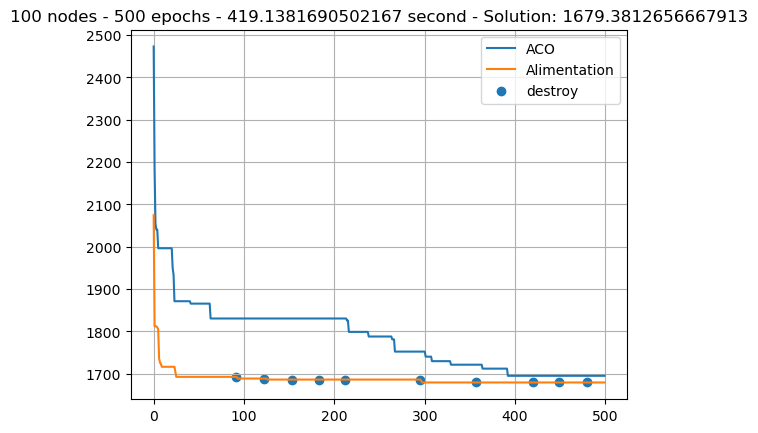

In [10]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(max_iteration), best_data, label = 'ACO')
plt.plot(torch.arange(max_iteration), best_cost_data, label = 'Alimentation')
plt.scatter(torch.tensor(destroy_data), torch.tensor(best_cost_data)[torch.tensor(destroy_data)], label = 'destroy')
plt.title("{} nodes - {} epochs - {} second - Solution: {}".format(cfg.graph_size ,max_iteration, time_run, best_cost))
plt.grid()
plt.legend()

In [11]:
final_path

{0: [1, 73, 76, 23, 57, 5, 1],
 1: [1, 29, 30, 79, 35, 69, 78, 1],
 2: [1, 53, 19, 7, 1],
 3: [1, 60, 100, 95, 97, 1],
 4: [1, 63, 12, 91, 67, 1],
 5: [1, 93, 43, 16, 88, 58, 98, 1],
 6: [1, 6, 62, 86, 38, 14, 1],
 7: [1, 40, 24, 68, 56, 26, 1],
 8: [1, 13, 77, 80, 4, 55, 25, 81, 1],
 9: [1, 28, 70, 31, 52, 21, 33, 71, 1],
 10: [1, 83, 9, 47, 90, 1],
 11: [1, 32, 89, 8, 1],
 12: [1, 46, 84, 85, 61, 1],
 13: [1, 66, 72, 10, 36, 1],
 14: [1, 96, 99, 17, 87, 18, 94, 1],
 15: [1, 64, 65, 50, 49, 1],
 16: [1, 41, 54, 27, 59, 1],
 17: [1, 34, 82, 51, 2, 1],
 18: [1, 37, 48, 20, 11, 1],
 19: [1, 3, 22, 74, 42, 75, 1],
 20: [1, 15, 45, 39, 44, 92, 101, 1]}

Optional

In [ ]:
for _ in range(10):
    ants_route, cost = BTNT[-1], max_travel
    for _ in range(1):
        travel_distance, ants_route = injection(ants_route, colony, 0.5)
    for _ in range(1):
        travel_distance, ants_route = cross_exchange(ants_route, colony)
    travel_distance, ants_route = local_search(ants_route, colony, n_customer, cfg.q)
    travel_distance, ants_route = ls3(ants_route)
    for _ in range(50):
        travel_distance, ants_route = ls_1route(ants_route, colony)
    BTNT, max_travel, max_route = save_solution(ants_route, travel_distance, BTNT, max_route, max_travel)
    print(max_travel, max_route)

In [15]:
final_solution = max(1000*max_route + max_travel, 1000*len(final_path.keys()) + best_cost)
final_solution

22679.38126566679

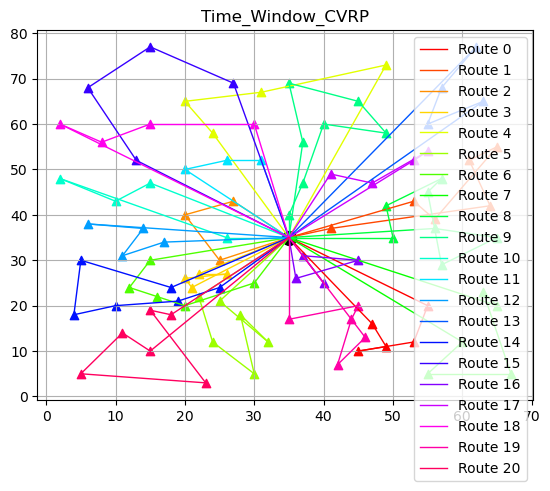

In [13]:
draw(final_path, colony)